# TP 1 : Optimisation sans contrainte

## Exercice 1 (énergie rayonnante d’un corps noir)

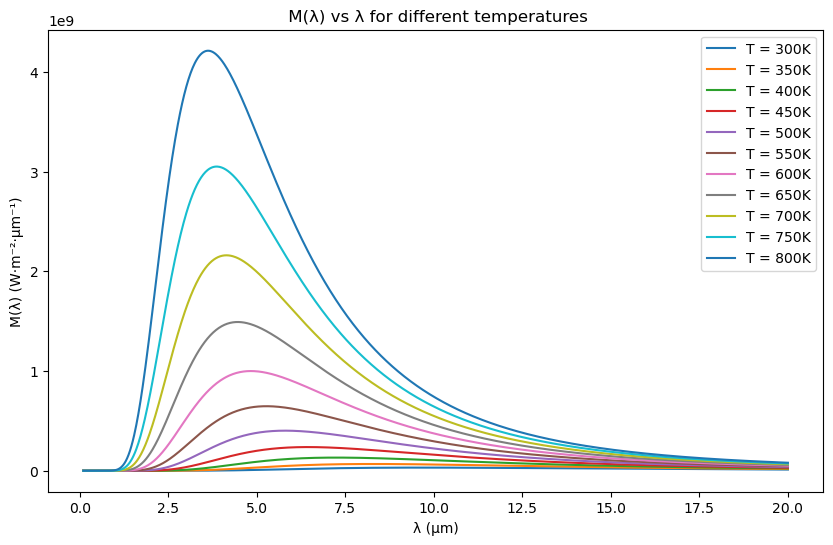

In [3]:
import numpy as np
import matplotlib.pyplot as plt


h = 6.625e-34  # Planck
C0 = 2.997e8
k = 1.380e-23  # Boltzmann
n = 1 

lambda_vals = np.linspace(1e-7, 2e-5, 1000)

def M_lambda(lambda_, T):
    numerator = 2 * np.pi * h * C0**2
    denominator = n**2 * lambda_**5 * (np.exp(h * C0 / (n * k * T * lambda_)) - 1)
    return numerator / denominator

T_list = np.arange(300, 801, 50)

plt.figure(figsize=(10, 6))
for T in T_list:
    M_vals = M_lambda(lambda_vals, T)
    plt.plot(lambda_vals * 1e6, M_vals, label=f"T = {T}K")

plt.xlabel("λ (μm)")
plt.ylabel("M(λ) (W·m⁻²·μm⁻¹)")
plt.title(" M(λ) vs λ for different temperatures")
plt.legend()
plt.show()


In [16]:
def golden_section_search(f, a, b, tol=1e-9, max_iter=1000):
    phi = (1 + np.sqrt(5)) / 2
    resphi = 2 - phi
    c = a + resphi * (b - a)
    d = b - resphi * (b - a)
    fc = f(c)
    fd = f(d)
    for i in range(max_iter):
        if abs(b - a) < tol:
            break
        if fc < fd:
            b = d
            d = c
            fd = fc
            c = a + resphi * (b - a)
            fc = f(c)
        else:
            a = c
            c = d
            fc = fd
            d = b - resphi * (b - a)
            fd = f(d)
    return (a + b) / 2

search_a = 1e-7
search_b = 1e-4

lambda_star_values = {}
for T in T_list:
    f = lambda l: -M_lambda(l, T)
    lambda_star = golden_section_search(f, search_a, search_b)
    lambda_star_values[T] = lambda_star

print("T (K)", "λ* (m)")
for T in T_list:
    print(T, f"{lambda_star_values[T]:.4e}")

T (K) λ* (m)
300 9.6592e-06
350 8.2795e-06
400 7.2444e-06
450 6.4394e-06
500 5.7954e-06
550 5.2685e-06
600 4.8296e-06
650 4.4582e-06
700 4.1394e-06
750 3.8637e-06
800 3.6220e-06


In [15]:
print("T (K)", "λ* (m)", "λ*T (m·K)", "M(λ*) (W·m⁻²·m⁻¹)", "M(λ*)/T^5")
for T in T_list:
    lam_star = lambda_star_values[T]
    M_max = M_lambda(lam_star, T)
    product = lam_star * T
    ratio = M_max / T**5
    print(T,f"{lam_star:.4e}",f"{product:.4e}",f"{M_max:.4e}",f"{ratio:.4e}")

T (K) λ* (m) λ*T (m·K) M(λ*) (W·m⁻²·m⁻¹) M(λ*)/T^5
300 9.6592e-06 2.8978e-03 3.1242e+07 1.2857e-05
350 8.2795e-06 2.8978e-03 6.7527e+07 1.2857e-05
400 7.2444e-06 2.8978e-03 1.3165e+08 1.2857e-05
450 6.4394e-06 2.8977e-03 2.3725e+08 1.2857e-05
500 5.7954e-06 2.8977e-03 4.0178e+08 1.2857e-05
550 5.2685e-06 2.8977e-03 6.4707e+08 1.2857e-05
600 4.8296e-06 2.8978e-03 9.9975e+08 1.2857e-05
650 4.4582e-06 2.8978e-03 1.4918e+09 1.2857e-05
700 4.1394e-06 2.8976e-03 2.1609e+09 1.2857e-05
750 3.8637e-06 2.8978e-03 3.0510e+09 1.2857e-05
800 3.6220e-06 2.8976e-03 4.2130e+09 1.2857e-05


## Exercice 2 (méthodes de type gradient pour des fonctions quadratiques)

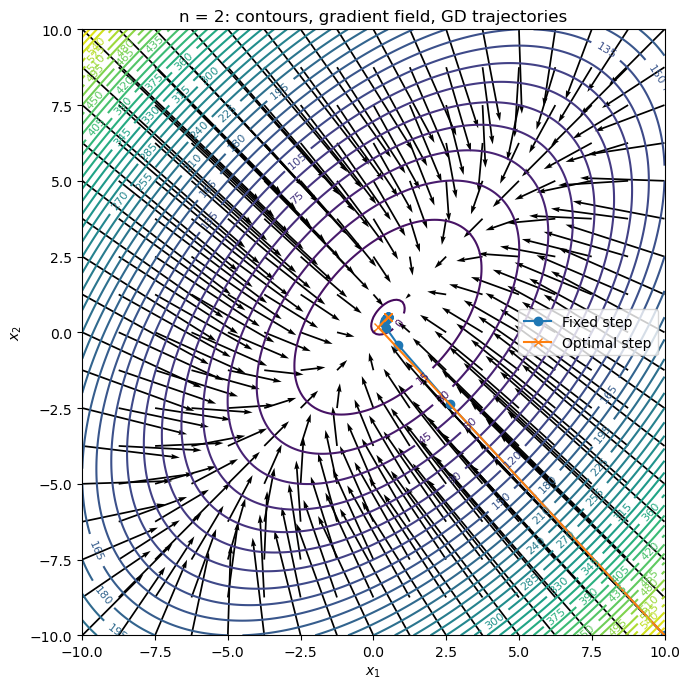

Benchmark Results:
n= 10, SPD=True, Fixed steps=  954, Optimal steps=  450
n= 20, SPD=True, Fixed steps= 3543, Optimal steps= 1754
n= 30, SPD=True, Fixed steps= 7799, Optimal steps= 3908
n= 50, SPD=True, Fixed steps=10000, Optimal steps=10000
n=100, SPD=True, Fixed steps=10000, Optimal steps=10000


In [7]:
# Gradient Descent Methods for Quadratic Function Minimization

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags

# ---------------- Matrix and Function Definitions ------------------
def A_n(n: int) -> np.ndarray:
    """Construct tridiagonal SPD matrix A_n."""
    return diags([[-2]*(n-1), [4]*n, [-2]*(n-1)], offsets=[-1, 0, 1]).toarray()

def b_n(n: int) -> np.ndarray:
    """Construct vector b_n of ones."""
    return np.ones(n)

def J(A: np.ndarray, b: np.ndarray, x: np.ndarray) -> float:
    """Quadratic cost function."""
    return 0.5 * x @ A @ x - b @ x

def gradJ(A: np.ndarray, b: np.ndarray, x: np.ndarray) -> np.ndarray:
    """Gradient of the quadratic cost."""
    return A @ x - b

# ---------------- Gradient Descent Algorithms ---------------------
def gd_fixed(A, b, x0, s, tol=1e-6, max_iter=50):
    x = x0.copy()
    path = [x.copy()]
    for _ in range(max_iter):
        g = gradJ(A, b, x)
        if np.linalg.norm(g) < tol:
            break
        x -= s * g
        path.append(x.copy())
    return np.array(path)

def gd_optimal(A, b, x0, tol=1e-6, max_iter=50):
    x = x0.copy()
    path = [x.copy()]
    for _ in range(max_iter):
        g = gradJ(A, b, x)
        if np.linalg.norm(g) < tol:
            break
        alpha = (g @ g) / (g @ (A @ g))
        x -= alpha * g
        path.append(x.copy())
    return np.array(path)

# ---------------- Visualization for n = 2 ------------------------
def plot_contours_and_paths():
    n = 2
    A = A_n(n)
    b = b_n(n)
    x0 = np.array([10.0, -10.0])
    s = 1 / 8

    path_fixed = gd_fixed(A, b, x0, s)
    path_opt = gd_optimal(A, b, x0)

    X = np.linspace(-10, 10, 201)
    Y = np.linspace(-10, 10, 201)
    XX, YY = np.meshgrid(X, Y)
    ZZ = 0.5 * (4*XX**2 - 4*XX*YY + 4*YY**2) - (XX + YY)

    fig, ax = plt.subplots(figsize=(7, 7))
    contours = ax.contour(XX, YY, ZZ, levels=40)
    ax.clabel(contours, inline=True, fontsize=8)


    for xi in np.linspace(-10, 10, 17):
        for yi in np.linspace(-10, 10, 17):
            g = gradJ(A, b, np.array([xi, yi]))
            ax.quiver(xi, yi, -g[0], -g[1], scale=200, width=0.003)

    ax.plot(*path_fixed.T, marker='o', label="Fixed step")
    ax.plot(*path_opt.T, marker='x', label="Optimal step")

    ax.set(xlim=(-10, 10), ylim=(-10, 10), xlabel=r"$x_1$", ylabel=r"$x_2$",
           title="n = 2: contours, gradient field, GD trajectories")
    ax.legend()
    plt.tight_layout()
    plt.show()

# ---------------- Benchmarking Function ---------------------------
def is_pos_def(A: np.ndarray) -> bool:
    try:
        np.linalg.cholesky(A)
        return True
    except np.linalg.LinAlgError:
        return False

def benchmark(n_values, fixed_step):
    results = {"n": [], "SPD?": [], "iter_fixed": [], "iter_opt": []}
    for n in n_values:
        A = A_n(n)
        b = b_n(n)
        results["SPD?"].append(is_pos_def(A))
        x0 = np.zeros(n)
        pf = gd_fixed(A, b, x0, fixed_step, tol=1e-8, max_iter=10000)
        po = gd_optimal(A, b, x0, tol=1e-8, max_iter=10000)
        results["n"].append(n)
        results["iter_fixed"].append(len(pf) - 1)
        results["iter_opt"].append(len(po) - 1)
    return results


# 可视化梯度路径和等高线图（n = 2）
plot_contours_and_paths()

# 输出不同维度的比较结果
n_list = [10, 20, 30, 50, 100]
step_fixed = 1 / 8
result = benchmark(n_list, step_fixed)

print("Benchmark Results:")
for row in zip(result["n"], result["SPD?"], result["iter_fixed"], result["iter_opt"]):
    print(f"n={row[0]:>3}, SPD={row[1]}, Fixed steps={row[2]:>5}, Optimal steps={row[3]:>5}")



## Exercice 3 (Fonction de Rosenbrock)